# Create Deep Neural Network for SF Analysis by Functional Term

In [ ]:
#!conda install pytorch torchvision torchaudio cpuonly -c pytorch -y

Overall R-squared: 0.17923836253747338
Average R2 out-of-sample: 0.1501937210559845


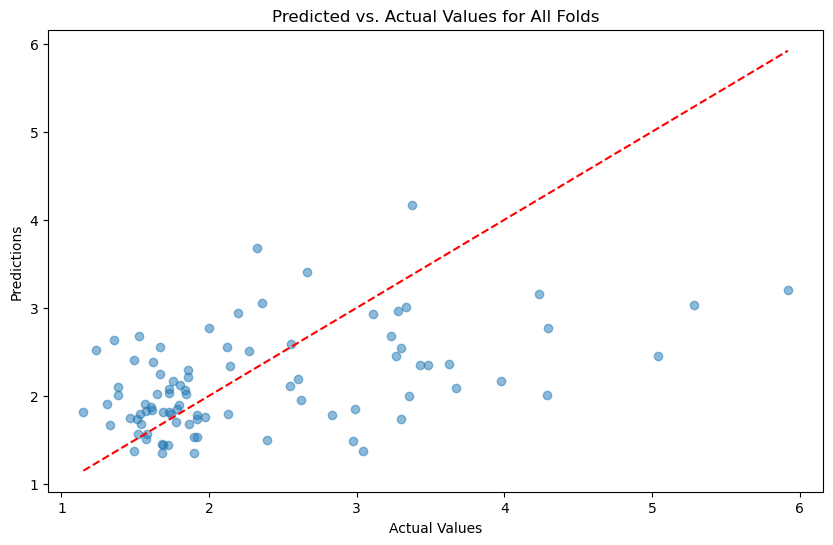

In [35]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

# Assuming 'Net', DataLoader, and other initial setup as previously defined

df = pd.read_csv("../data/sf_by_term_grouped_ml_cont_88_df.csv")
#df = pd.read_csv("../data/sf_by_term_grouped_ml_cont_314_df.csv")
features = df.drop('fold_change', axis=1).values
labels = df['fold_change'].values

features = torch.tensor(features, dtype=torch.float32)
labels = torch.tensor(labels, dtype=torch.float32).view(-1, 1)

# Define the model architecture
class Net(nn.Module):
    def __init__(self, num_features):
        super(Net, self).__init__()
        self.layer1 = nn.Linear(num_features, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, 1)
    
    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        return self.layer3(x)

kf = KFold(n_splits=4, shuffle=True, random_state=42)

all_predictions = []
all_actuals = []
r2_values = []

for train_idx, val_idx in kf.split(features):
    X_train, X_val = features[train_idx], features[val_idx]
    y_train, y_val = labels[train_idx], labels[val_idx]

    normalizer = nn.BatchNorm1d(X_train.size(1))
    X_train = normalizer(X_train)
    X_val = normalizer(X_val)

    train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=32, shuffle=True)
    val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=32)

    model = Net(num_features=X_train.size(1))
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(100):
        model.train()
        for batch_features, batch_labels in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_features)
            loss = criterion(outputs, batch_labels)
            loss.backward(retain_graph = True)
            optimizer.step()

    model.eval()
    with torch.no_grad():
        predictions = []
        actuals = []
        for batch_features, batch_labels in val_loader:
            outputs = model(batch_features)
            predictions.extend(outputs.numpy().flatten())
            actuals.extend(batch_labels.numpy().flatten())

    all_predictions.extend(predictions)
    all_actuals.extend(actuals)

    fold_predictions = np.array(predictions)
    fold_actuals = np.array(actuals)

    mse = np.mean((fold_actuals - fold_predictions) ** 2)
    in_sample_variance = np.var(fold_actuals, ddof=1)
    n = len(fold_actuals)

    r2_fold = 1 - (mse / in_sample_variance)
    r2_values.append(r2_fold)

# Compute R-squared value
r_squared = r2_score(all_actuals, all_predictions)
print(f"Overall R-squared: {r_squared}")

# Compute average R2 out-of-sample
avg_r2_out_of_sample = np.mean(r2_values)
print(f"Average R2 out-of-sample: {avg_r2_out_of_sample}")

# Plot Predicted vs. Actual values
plt.figure(figsize=(10, 6))
plt.scatter(all_actuals, all_predictions, alpha=0.5)
plt.plot([min(all_actuals), max(all_actuals)], [min(all_actuals), max(all_actuals)], 'r--')  # Ideal line
plt.xlabel('Actual Values')
plt.ylabel('Predictions')
plt.title('Predicted vs. Actual Values for All Folds')
plt.show()

In [53]:
# Save data as .csv for plotting in R
sf_prediction_dnn_df_data = {"actual_fold_change":  all_actuals,
                             "predicted_fold_change": all_predictions,
                             "overall_r2": r_squared,
                             "average_r2oos": avg_r2_out_of_sample}

sf_prediction_dnn_df = pd.DataFrame(sf_prediction_dnn_df_data)

In [45]:
sf_prediction_dnn_df.to_csv("../data/misc/sf_prediction_dnn_results.csv", index = False)

# SVM Classification of High SF or Low SF

In [67]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from scipy import interp
from sklearn import svm

# Load the dataset
df = pd.read_csv("../data/sf_by_term_grouped_ml_binary_88_df.csv")

# Define features and target
X = df.drop('sf_strength_binary', axis=1).values
y = df['sf_strength_binary'].values

# Initialize KFold parameters
kf = KFold(n_splits = 4, shuffle=True, random_state=np.random.RandomState(0))

# Initialize list to store TPRs, AUC scores, and mean FPR
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
accuracies = []

# Iterate over folds
for train_index, test_index in kf.split(X):
    # Split dataset
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Standardize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Fit logistic regression model
    #model = LogisticRegression(max_iter=1000)
    model = svm.SVC(kernel="linear", probability=True, random_state=np.random.RandomState(0))
    model.fit(X_train_scaled, y_train)

    # Predict probabilities
    y_proba = model.predict_proba(X_test_scaled)[:, 1]
    y_pred = model.predict(X_test_scaled)
    
    # Compute ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)

    # Compute accuracy
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)

    # Interpolate TPR at mean FPR points
    tpr_interp = np.interp(mean_fpr, fpr, tpr)
    tpr_interp[0] = 0.0  # Ensure starting at 0
    tprs.append(tpr_interp)

# Compute mean and standard deviation of TPRs
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0  # Ensure ends at 1
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
mean_accuracy = np.mean(accuracies)

# Print mean accuracy along with AUC
print(f"Mean AUC: {mean_auc:.4f} ± {std_auc:.4f}")
print(f"Mean Accuracy: {mean_accuracy:.4f}")

Mean AUC: 0.8532 ± 0.0262
Mean Accuracy: 0.7614


(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 [Text(0, -0.2, '−0.2'),
  Text(0, 0.0, '0.0'),
  Text(0, 0.2, '0.2'),
  Text(0, 0.4000000000000001, '0.4'),
  Text(0, 0.6000000000000001, '0.6'),
  Text(0, 0.8, '0.8'),
  Text(0, 1.0000000000000002, '1.0'),
  Text(0, 1.2000000000000002, '1.2')])

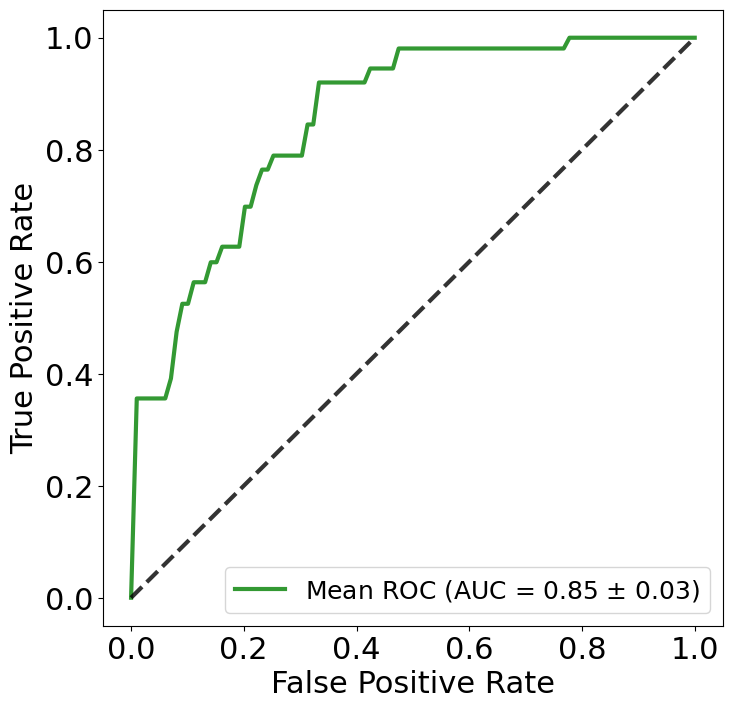

In [68]:
# Plot the mean ROC curve
fig = plt.figure(figsize=[8,8])
plt.plot(mean_fpr, mean_tpr, color='g',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=3, alpha=.8)

# Plot a line for random guessing
plt.plot([0, 1], [0, 1], linestyle='--', lw=3, color='black', alpha=.8)

# Finalize plot
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize = 22)
plt.ylabel('True Positive Rate', fontsize = 22)
plt.legend(loc="lower right", fontsize = 18)
plt.xticks(fontsize = 22)
plt.yticks(fontsize = 22)
#fig.savefig("../figures/subplots/fig4_sf_svm_roc.png", format='png', dpi=300, bbox_inches="tight")

In [69]:
# Save data as .csv for plotting in R
sf_prediction_svm_df_data = {"mean_fpr":  mean_fpr,
                             "mean_tpr": mean_tpr,
                             "mean_auc": mean_auc,
                             "std_auc": std_auc,
                             "mean_accuracy": mean_accuracy}

sf_prediction_svm_df = pd.DataFrame(sf_prediction_svm_df_data)

In [70]:
sf_prediction_svm_df.to_csv("../data/misc/sf_prediction_svm_results.csv", index = False)